# Afriat

In [1]:
ood_seed = 14

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('30', 'Pericentral', 'Uninfected')


Removed datapoint: 597

train         14745
validation     3711
ood             597
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 51%|█████     | 9668/19053 [00:00<00:00, 96669.49it/s]

100%|██████████| 19053/19053 [00:00<00:00, 97797.17it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 993140.88it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 314.92it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:09:32, 10.46s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:09:32, 10.46s/it, v_num=1, recon=3.97e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.255, acc_zone=0.73, acc_status_control=0.482]

Epoch 2/400:   0%|          | 1/400 [00:10<1:09:32, 10.46s/it, v_num=1, recon=3.97e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.255, acc_zone=0.73, acc_status_control=0.482]

Epoch 2/400:   0%|          | 2/400 [00:20<1:07:43, 10.21s/it, v_num=1, recon=3.97e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.255, acc_zone=0.73, acc_status_control=0.482]

Epoch 2/400:   0%|          | 2/400 [00:20<1:07:43, 10.21s/it, v_num=1, recon=3.25e+3, r2_mean=0.61, adv_loss=2.9, acc_pert=0.346, acc_zone=0.819, acc_status_control=0.615] 

Epoch 3/400:   0%|          | 2/400 [00:20<1:07:43, 10.21s/it, v_num=1, recon=3.25e+3, r2_mean=0.61, adv_loss=2.9, acc_pert=0.346, acc_zone=0.819, acc_status_control=0.615]

Epoch 3/400:   1%|          | 3/400 [00:30<1:06:58, 10.12s/it, v_num=1, recon=3.25e+3, r2_mean=0.61, adv_loss=2.9, acc_pert=0.346, acc_zone=0.819, acc_status_control=0.615]

Epoch 3/400:   1%|          | 3/400 [00:30<1:06:58, 10.12s/it, v_num=1, recon=3.19e+3, r2_mean=0.712, adv_loss=2.81, acc_pert=0.368, acc_zone=0.83, acc_status_control=0.616]

Epoch 4/400:   1%|          | 3/400 [00:30<1:06:58, 10.12s/it, v_num=1, recon=3.19e+3, r2_mean=0.712, adv_loss=2.81, acc_pert=0.368, acc_zone=0.83, acc_status_control=0.616]

Epoch 4/400:   1%|          | 4/400 [00:40<1:06:23, 10.06s/it, v_num=1, recon=3.19e+3, r2_mean=0.712, adv_loss=2.81, acc_pert=0.368, acc_zone=0.83, acc_status_control=0.616]

Epoch 4/400:   1%|          | 4/400 [00:40<1:06:23, 10.06s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.414, acc_zone=0.835, acc_status_control=0.609]

Epoch 5/400:   1%|          | 4/400 [00:40<1:06:23, 10.06s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.414, acc_zone=0.835, acc_status_control=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:50<1:06:04, 10.04s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.7, acc_pert=0.414, acc_zone=0.835, acc_status_control=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:50<1:06:04, 10.04s/it, v_num=1, recon=3.16e+3, r2_mean=0.773, adv_loss=2.5, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.609] 

Epoch 6/400:   1%|▏         | 5/400 [00:50<1:06:04, 10.04s/it, v_num=1, recon=3.16e+3, r2_mean=0.773, adv_loss=2.5, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.609]

Epoch 6/400:   2%|▏         | 6/400 [01:00<1:05:56, 10.04s/it, v_num=1, recon=3.16e+3, r2_mean=0.773, adv_loss=2.5, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.609]

Epoch 6/400:   2%|▏         | 6/400 [01:00<1:05:56, 10.04s/it, v_num=1, recon=3.15e+3, r2_mean=0.788, adv_loss=2.3, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.625]

Epoch 7/400:   2%|▏         | 6/400 [01:00<1:05:56, 10.04s/it, v_num=1, recon=3.15e+3, r2_mean=0.788, adv_loss=2.3, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.625]

Epoch 7/400:   2%|▏         | 7/400 [01:10<1:05:42, 10.03s/it, v_num=1, recon=3.15e+3, r2_mean=0.788, adv_loss=2.3, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.625]

Epoch 7/400:   2%|▏         | 7/400 [01:10<1:05:42, 10.03s/it, v_num=1, recon=3.14e+3, r2_mean=0.798, adv_loss=2.2, acc_pert=0.589, acc_zone=0.845, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 7/400 [01:10<1:05:42, 10.03s/it, v_num=1, recon=3.14e+3, r2_mean=0.798, adv_loss=2.2, acc_pert=0.589, acc_zone=0.845, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 8/400 [01:20<1:05:20, 10.00s/it, v_num=1, recon=3.14e+3, r2_mean=0.798, adv_loss=2.2, acc_pert=0.589, acc_zone=0.845, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 8/400 [01:20<1:05:20, 10.00s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.12, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.635]

Epoch 9/400:   2%|▏         | 8/400 [01:20<1:05:20, 10.00s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.12, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.635]

Epoch 9/400:   2%|▏         | 9/400 [01:30<1:05:07,  9.99s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.12, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.635]

Epoch 9/400:   2%|▏         | 9/400 [01:30<1:05:07,  9.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.622] 

Epoch 10/400:   2%|▏         | 9/400 [01:30<1:05:07,  9.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.622]


disnt_basal = 1.2329570224965936

disnt_after = 1.9215813885916448

val_r2_mean = 0.8174721979686914

val_r2_var = 0.20105904011599918


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [02:02<1:49:46, 16.89s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.622]

Epoch 10/400:   2%|▎         | 10/400 [02:02<1:49:46, 16.89s/it, v_num=1, recon=3.12e+3, r2_mean=0.811, adv_loss=2.14, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.611, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [02:02<1:49:46, 16.89s/it, v_num=1, recon=3.12e+3, r2_mean=0.811, adv_loss=2.14, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.611, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:12<1:35:52, 14.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.811, adv_loss=2.14, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.611, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:12<1:35:52, 14.79s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.1, acc_pert=0.641, acc_zone=0.849, acc_status_control=0.618, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [02:12<1:35:52, 14.79s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.1, acc_pert=0.641, acc_zone=0.849, acc_status_control=0.618, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:22<1:26:16, 13.34s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.1, acc_pert=0.641, acc_zone=0.849, acc_status_control=0.618, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:22<1:26:16, 13.34s/it, v_num=1, recon=3.11e+3, r2_mean=0.817, adv_loss=2, acc_pert=0.665, acc_zone=0.854, acc_status_control=0.624, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]  

Epoch 13/400:   3%|▎         | 12/400 [02:22<1:26:16, 13.34s/it, v_num=1, recon=3.11e+3, r2_mean=0.817, adv_loss=2, acc_pert=0.665, acc_zone=0.854, acc_status_control=0.624, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:32<1:19:34, 12.34s/it, v_num=1, recon=3.11e+3, r2_mean=0.817, adv_loss=2, acc_pert=0.665, acc_zone=0.854, acc_status_control=0.624, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:32<1:19:34, 12.34s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=1.96, acc_pert=0.683, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:32<1:19:34, 12.34s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=1.96, acc_pert=0.683, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:42<1:14:44, 11.62s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=1.96, acc_pert=0.683, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:42<1:14:44, 11.62s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.627, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:42<1:14:44, 11.62s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.627, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:52<1:11:37, 11.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.627, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:52<1:11:37, 11.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.98, acc_pert=0.665, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:52<1:11:37, 11.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.98, acc_pert=0.665, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:02<1:09:13, 10.82s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.98, acc_pert=0.665, acc_zone=0.855, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:02<1:09:13, 10.82s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [03:02<1:09:13, 10.82s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:12<1:07:28, 10.57s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:12<1:07:28, 10.57s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [03:12<1:07:28, 10.57s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:22<1:06:18, 10.42s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.644, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:22<1:06:18, 10.42s/it, v_num=1, recon=3.08e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.684, acc_zone=0.853, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [03:22<1:06:18, 10.42s/it, v_num=1, recon=3.08e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.684, acc_zone=0.853, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:32<1:05:21, 10.29s/it, v_num=1, recon=3.08e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.684, acc_zone=0.853, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:32<1:05:21, 10.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.684, acc_zone=0.856, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:32<1:05:21, 10.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.684, acc_zone=0.856, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]


disnt_basal = 1.2291567703947237

disnt_after = 1.913804054045627

val_r2_mean = 0.820871687885203

val_r2_var = 0.23115319894408087


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [04:12<2:01:08, 19.13s/it, v_num=1, recon=3.07e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.684, acc_zone=0.856, acc_status_control=0.646, val_recon=3.16e+3, disnt_basal=1.23, disnt_after=1.92, val_r2_mean=0.817, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [04:12<2:01:08, 19.13s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.92, acc_pert=0.689, acc_zone=0.853, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [04:12<2:01:08, 19.13s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.92, acc_pert=0.689, acc_zone=0.853, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:24<1:46:13, 16.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.92, acc_pert=0.689, acc_zone=0.853, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:24<1:46:13, 16.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.659, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [04:24<1:46:13, 16.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.659, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:34<1:34:00, 14.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.659, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:34<1:34:00, 14.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.694, acc_zone=0.856, acc_status_control=0.656, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:34<1:34:00, 14.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.694, acc_zone=0.856, acc_status_control=0.656, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:44<1:24:35, 13.46s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.694, acc_zone=0.856, acc_status_control=0.656, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:44<1:24:35, 13.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.92, acc_pert=0.692, acc_zone=0.853, acc_status_control=0.646, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:44<1:24:35, 13.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.92, acc_pert=0.692, acc_zone=0.853, acc_status_control=0.646, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:54<1:18:03, 12.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.92, acc_pert=0.692, acc_zone=0.853, acc_status_control=0.646, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:54<1:18:03, 12.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.69, acc_zone=0.852, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]  

Epoch 25/400:   6%|▌         | 24/400 [04:54<1:18:03, 12.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.69, acc_zone=0.852, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:04<1:13:32, 11.77s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.69, acc_zone=0.852, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:04<1:13:32, 11.77s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.93, acc_pert=0.684, acc_zone=0.854, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [05:05<1:13:32, 11.77s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.93, acc_pert=0.684, acc_zone=0.854, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:15<1:10:29, 11.31s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.93, acc_pert=0.684, acc_zone=0.854, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:15<1:10:29, 11.31s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.677, acc_zone=0.85, acc_status_control=0.648, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [05:15<1:10:29, 11.31s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.677, acc_zone=0.85, acc_status_control=0.648, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:25<1:08:00, 10.94s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.96, acc_pert=0.677, acc_zone=0.85, acc_status_control=0.648, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:25<1:08:00, 10.94s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.682, acc_zone=0.851, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:25<1:08:00, 10.94s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.682, acc_zone=0.851, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:35<1:06:15, 10.69s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.682, acc_zone=0.851, acc_status_control=0.654, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:35<1:06:15, 10.69s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [05:35<1:06:15, 10.69s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:45<1:04:52, 10.49s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:45<1:04:52, 10.49s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.671, acc_zone=0.85, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]  

Epoch 30/400:   7%|▋         | 29/400 [05:45<1:04:52, 10.49s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.671, acc_zone=0.85, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.2191989078156644

disnt_after = 1.9034736036943705

val_r2_mean = 0.8289313290369534

val_r2_var = 0.2467668510502105


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [06:24<1:58:06, 19.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.98, acc_pert=0.671, acc_zone=0.85, acc_status_control=0.65, val_recon=3.12e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:24<1:58:06, 19.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.853, acc_status_control=0.649, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:24<1:58:06, 19.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.853, acc_status_control=0.649, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:36<1:43:39, 16.86s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.674, acc_zone=0.853, acc_status_control=0.649, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:36<1:43:39, 16.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]    

Epoch 32/400:   8%|▊         | 31/400 [06:36<1:43:39, 16.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:46<1:30:34, 14.77s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:46<1:30:34, 14.77s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.668, acc_zone=0.852, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [06:46<1:30:34, 14.77s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.668, acc_zone=0.852, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:56<1:21:17, 13.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.668, acc_zone=0.852, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:56<1:21:17, 13.29s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2, acc_pert=0.667, acc_zone=0.852, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]   

Epoch 34/400:   8%|▊         | 33/400 [06:56<1:21:17, 13.29s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2, acc_pert=0.667, acc_zone=0.852, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:05<1:14:24, 12.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2, acc_pert=0.667, acc_zone=0.852, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:05<1:14:24, 12.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.66, acc_zone=0.848, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [07:05<1:14:24, 12.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.66, acc_zone=0.848, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:15<1:09:43, 11.46s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.02, acc_pert=0.66, acc_zone=0.848, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:15<1:09:43, 11.46s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.651, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [07:15<1:09:43, 11.46s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.651, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:25<1:06:28, 10.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.01, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.651, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:25<1:06:28, 10.96s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]  

Epoch 37/400:   9%|▉         | 36/400 [07:25<1:06:28, 10.96s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:34<1:04:09, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.656, acc_zone=0.85, acc_status_control=0.652, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:34<1:04:09, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.638, acc_zone=0.848, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [07:34<1:04:09, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.638, acc_zone=0.848, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:44<1:02:29, 10.36s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.638, acc_zone=0.848, acc_status_control=0.648, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:44<1:02:29, 10.36s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.645, acc_zone=0.851, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [07:44<1:02:29, 10.36s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.645, acc_zone=0.851, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:54<1:01:35, 10.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.05, acc_pert=0.645, acc_zone=0.851, acc_status_control=0.655, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:54<1:01:35, 10.24s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.643, acc_zone=0.847, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [07:54<1:01:35, 10.24s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.643, acc_zone=0.847, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1981638002635062

disnt_after = 1.9008772329817618

val_r2_mean = 0.8298649348021108

val_r2_var = 0.27012611085283644


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [08:36<1:58:39, 19.78s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.643, acc_zone=0.847, acc_status_control=0.654, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [08:36<1:58:39, 19.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.847, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 41/400:  10%|█         | 40/400 [08:36<1:58:39, 19.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.847, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:50<1:47:01, 17.89s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.847, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:50<1:47:01, 17.89s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [08:50<1:47:01, 17.89s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:04<1:39:41, 16.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:04<1:39:41, 16.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.652, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [09:04<1:39:41, 16.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.652, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:14<1:27:34, 14.72s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.652, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:14<1:27:34, 14.72s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 44/400:  11%|█         | 43/400 [09:14<1:27:34, 14.72s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:24<1:19:04, 13.33s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:24<1:19:04, 13.33s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [09:24<1:19:04, 13.33s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:34<1:13:41, 12.46s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.848, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:34<1:13:41, 12.46s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]    

Epoch 46/400:  11%|█▏        | 45/400 [09:34<1:13:41, 12.46s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:44<1:09:04, 11.71s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.65, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:44<1:09:04, 11.71s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [09:44<1:09:04, 11.71s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:54<1:05:57, 11.21s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.651, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:54<1:05:57, 11.21s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [09:54<1:05:57, 11.21s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:04<1:03:43, 10.86s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.646, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:04<1:03:43, 10.86s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [10:04<1:03:43, 10.86s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:14<1:02:00, 10.60s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.647, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:14<1:02:00, 10.60s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [10:14<1:02:00, 10.60s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2097869250878843

disnt_after = 1.900978405056919

val_r2_mean = 0.8301142794386341

val_r2_var = 0.2652201704175053

Epoch 50/400:  12%|█▎        | 50/400 [10:54<1:52:11, 19.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.649, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [10:54<1:52:11, 19.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.615, acc_zone=0.843, acc_status_control=0.646, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [10:54<1:52:11, 19.23s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.615, acc_zone=0.843, acc_status_control=0.646, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:04<1:35:57, 16.50s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.615, acc_zone=0.843, acc_status_control=0.646, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:04<1:35:57, 16.50s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [11:04<1:35:57, 16.50s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [11:16<1:28:13, 15.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [11:16<1:28:13, 15.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [11:16<1:28:13, 15.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:27<1:20:47, 13.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:27<1:20:47, 13.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [11:27<1:20:47, 13.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:38<1:15:29, 13.09s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:38<1:15:29, 13.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [11:38<1:15:29, 13.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:49<1:11:52, 12.50s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:49<1:11:52, 12.50s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [11:49<1:11:52, 12.50s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:00<1:09:08, 12.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:00<1:09:08, 12.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.601, acc_zone=0.844, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [12:00<1:09:08, 12.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.601, acc_zone=0.844, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:11<1:07:28, 11.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.601, acc_zone=0.844, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:11<1:07:28, 11.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.647, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [12:11<1:07:28, 11.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.647, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:23<1:06:13, 11.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.647, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:23<1:06:13, 11.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [12:23<1:06:13, 11.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:34<1:05:11, 11.47s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:34<1:05:11, 11.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [12:34<1:05:11, 11.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1917847207880397

disnt_after = 1.900782500837169

val_r2_mean = 0.8309240943266856

val_r2_var = 0.2703180378458595


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [13:13<1:51:30, 19.68s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [13:13<1:51:30, 19.68s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [13:13<1:51:30, 19.68s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:23<1:35:59, 16.99s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:23<1:35:59, 16.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.642, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [13:23<1:35:59, 16.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.642, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:34<1:24:19, 14.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.642, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:34<1:24:19, 14.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [13:34<1:24:19, 14.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:44<1:16:05, 13.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.645, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:44<1:16:05, 13.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [13:44<1:16:05, 13.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:54<1:10:03, 12.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:54<1:10:03, 12.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [13:54<1:10:03, 12.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:04<1:05:42, 11.77s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:04<1:05:42, 11.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.845, acc_status_control=0.65, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 65/400 [14:04<1:05:42, 11.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.845, acc_status_control=0.65, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:14<1:02:43, 11.27s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.2, acc_pert=0.587, acc_zone=0.845, acc_status_control=0.65, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:14<1:02:43, 11.27s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.651, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [14:14<1:02:43, 11.27s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.651, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [14:24<1:00:36, 10.92s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.651, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [14:24<1:00:36, 10.92s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [14:24<1:00:36, 10.92s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:34<59:02, 10.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]  

Epoch 68/400:  17%|█▋        | 68/400 [14:34<59:02, 10.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [14:34<59:02, 10.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:45<58:22, 10.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.647, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:45<58:22, 10.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [14:45<58:22, 10.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.198892162841055

disnt_after = 1.902640890534888

val_r2_mean = 0.833113797561375

val_r2_var = 0.2732930981802004

Epoch 70/400:  18%|█▊        | 70/400 [15:24<1:45:10, 19.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.644, val_recon=3.03e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [15:24<1:45:10, 19.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [15:24<1:45:10, 19.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:38<1:37:35, 17.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:38<1:37:35, 17.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [15:38<1:37:35, 17.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:49<1:24:46, 15.51s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:49<1:24:46, 15.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [15:49<1:24:46, 15.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:59<1:15:40, 13.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:59<1:15:40, 13.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [15:59<1:15:40, 13.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:09<1:09:14, 12.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:09<1:09:14, 12.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [16:09<1:09:14, 12.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:19<1:04:33, 11.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:19<1:04:33, 11.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [16:19<1:04:33, 11.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:29<1:01:29, 11.39s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:29<1:01:29, 11.39s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [16:29<1:01:29, 11.39s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [16:39<59:06, 10.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.648, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 77/400 [16:39<59:06, 10.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [16:39<59:06, 10.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:49<57:22, 10.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:49<57:22, 10.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [16:49<57:22, 10.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:59<56:20, 10.53s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.647, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:59<56:20, 10.53s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [16:59<56:20, 10.53s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1832515098653096

disnt_after = 1.896470028126672

val_r2_mean = 0.8313223294069843

val_r2_var = 0.2837534487015561


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [17:48<1:57:22, 22.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.646, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [17:48<1:57:22, 22.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]  

Epoch 81/400:  20%|██        | 80/400 [17:48<1:57:22, 22.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:58<1:37:51, 18.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:58<1:37:51, 18.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [17:58<1:37:51, 18.41s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:08<1:25:00, 16.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:08<1:25:00, 16.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [18:08<1:25:00, 16.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:18<1:15:04, 14.21s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:18<1:15:04, 14.21s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [18:18<1:15:04, 14.21s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:28<1:08:07, 12.94s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:28<1:08:07, 12.94s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [18:28<1:08:07, 12.94s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:38<1:03:27, 12.09s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:38<1:03:27, 12.09s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [18:38<1:03:27, 12.09s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [18:48<1:00:07, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [18:48<1:00:07, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [18:48<1:00:07, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:08<1:12:31, 13.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.24, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:08<1:12:31, 13.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [19:08<1:12:31, 13.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:18<1:06:19, 12.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:18<1:06:19, 12.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [19:18<1:06:19, 12.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:28<1:01:59, 11.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:28<1:01:59, 11.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]  

Epoch 90/400:  22%|██▏       | 89/400 [19:28<1:01:59, 11.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1821302260645936

disnt_after = 1.8952550258063001

val_r2_mean = 0.8292084288894896

val_r2_var = 0.291591426083871

Epoch 90/400:  22%|██▎       | 90/400 [20:11<1:50:19, 21.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [20:11<1:50:19, 21.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [20:11<1:50:19, 21.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:23<1:35:12, 18.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:23<1:35:12, 18.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [20:23<1:35:12, 18.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:33<1:22:08, 16.00s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:33<1:22:08, 16.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [20:33<1:22:08, 16.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:44<1:12:49, 14.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:44<1:12:49, 14.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [20:44<1:12:49, 14.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:54<1:06:11, 12.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:54<1:06:11, 12.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [20:54<1:06:11, 12.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [21:04<1:01:28, 12.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [21:04<1:01:28, 12.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [21:04<1:01:28, 12.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [21:14<58:11, 11.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]  

Epoch 96/400:  24%|██▍       | 96/400 [21:14<58:11, 11.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [21:14<58:11, 11.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:24<55:54, 11.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:24<55:54, 11.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [21:24<55:54, 11.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:34<54:04, 10.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.65, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:34<54:04, 10.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [21:34<54:04, 10.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:44<52:50, 10.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:44<52:50, 10.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [21:44<52:50, 10.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.184417615354022

disnt_after = 1.899152780561669

val_r2_mean = 0.8329078106854891

val_r2_var = 0.28296119044489226


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [22:26<1:40:07, 20.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [22:26<1:40:07, 20.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [22:26<1:40:07, 20.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:36<1:24:45, 17.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:36<1:24:45, 17.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]  

Epoch 102/400:  25%|██▌       | 101/400 [22:36<1:24:45, 17.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:46<1:14:04, 14.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:46<1:14:04, 14.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [22:46<1:14:04, 14.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:56<1:06:37, 13.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:56<1:06:37, 13.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [22:56<1:06:37, 13.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [23:06<1:01:26, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [23:06<1:01:26, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [23:06<1:01:26, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [23:19<1:02:17, 12.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [23:19<1:02:17, 12.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [23:19<1:02:17, 12.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [23:29<58:13, 11.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]  

Epoch 106/400:  26%|██▋       | 106/400 [23:29<58:13, 11.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [23:29<58:13, 11.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:39<55:24, 11.35s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:39<55:24, 11.35s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [23:39<55:24, 11.35s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:50<53:23, 10.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:50<53:23, 10.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [23:50<53:23, 10.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [24:00<51:45, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.648, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [24:00<51:45, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [24:00<51:45, 10.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1833729898348604

disnt_after = 1.892728425003715

val_r2_mean = 0.8331509492167064

val_r2_var = 0.29261978253833315

Epoch 110/400:  28%|██▊       | 110/400 [24:34<1:25:51, 17.77s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.833, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [24:34<1:25:51, 17.77s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [24:34<1:25:51, 17.77s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:44<1:15:06, 15.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:44<1:15:06, 15.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [24:44<1:15:06, 15.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:55<1:07:37, 14.09s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:55<1:07:37, 14.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [24:55<1:07:37, 14.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [25:05<1:01:37, 12.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [25:05<1:01:37, 12.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [25:05<1:01:37, 12.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [25:16<57:57, 12.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 114/400 [25:16<57:57, 12.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [25:16<57:57, 12.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [25:25<54:27, 11.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [25:25<54:27, 11.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [25:25<54:27, 11.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:35<51:51, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:35<51:51, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]  

Epoch 117/400:  29%|██▉       | 116/400 [25:35<51:51, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:45<49:57, 10.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:45<49:57, 10.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [25:45<49:57, 10.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:57<51:42, 11.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:57<51:42, 11.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [25:57<51:42, 11.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [26:12<57:55, 12.37s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [26:12<57:55, 12.37s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [26:12<57:55, 12.37s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1842477871195083

disnt_after = 1.896422919214574

val_r2_mean = 0.8301104753722326

val_r2_var = 0.28474297028742546

Epoch 120/400:  30%|███       | 120/400 [27:13<2:05:11, 26.83s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [27:13<2:05:11, 26.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 121/400:  30%|███       | 120/400 [27:13<2:05:11, 26.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [27:23<1:41:29, 21.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [27:23<1:41:29, 21.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [27:23<1:41:29, 21.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:33<1:24:30, 18.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:33<1:24:30, 18.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [27:33<1:24:30, 18.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [27:43<1:12:31, 15.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.647, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [27:43<1:12:31, 15.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [27:43<1:12:31, 15.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [27:53<1:05:14, 14.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [27:53<1:05:14, 14.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [27:53<1:05:14, 14.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [28:04<1:00:42, 13.25s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [28:04<1:00:42, 13.25s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [28:04<1:00:42, 13.25s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [28:15<57:25, 12.57s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 126/400:  32%|███▏      | 126/400 [28:15<57:25, 12.57s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [28:15<57:25, 12.57s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [28:27<55:08, 12.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [28:27<55:08, 12.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [28:27<55:08, 12.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:38<53:32, 11.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.648, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:38<53:32, 11.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [28:38<53:32, 11.81s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [28:49<52:18, 11.58s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [28:49<52:18, 11.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [28:49<52:18, 11.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1784334569506159

disnt_after = 1.882607376958311

val_r2_mean = 0.8339502445425727

val_r2_var = 0.29701359041632

Epoch 130/400:  32%|███▎      | 130/400 [29:22<1:21:45, 18.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.646, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [29:22<1:21:45, 18.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [29:22<1:21:45, 18.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [29:32<1:10:34, 15.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [29:32<1:10:34, 15.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [29:32<1:10:34, 15.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:42<1:02:22, 13.96s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:42<1:02:22, 13.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [29:42<1:02:22, 13.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [29:52<56:38, 12.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 133/400 [29:52<56:38, 12.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [29:52<56:38, 12.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [30:02<53:04, 11.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [30:02<53:04, 11.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [30:02<53:04, 11.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [30:12<49:58, 11.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [30:12<49:58, 11.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [30:12<49:58, 11.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [30:22<47:50, 10.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [30:22<47:50, 10.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [30:22<47:50, 10.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [30:32<46:17, 10.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [30:32<46:17, 10.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [30:32<46:17, 10.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:42<45:20, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:42<45:20, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [30:42<45:20, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:51<44:32, 10.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:51<44:32, 10.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [30:52<44:32, 10.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1766539888651517

disnt_after = 1.8854926569272819

val_r2_mean = 0.8338863222149198

val_r2_var = 0.29999751158417703

Epoch 140/400:  35%|███▌      | 140/400 [31:42<1:36:26, 22.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [31:42<1:36:26, 22.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [31:42<1:36:26, 22.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:53<1:21:44, 18.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.646, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:53<1:21:44, 18.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [31:53<1:21:44, 18.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [32:06<1:14:25, 17.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [32:06<1:14:25, 17.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [32:06<1:14:25, 17.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [32:17<1:05:12, 15.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [32:17<1:05:12, 15.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [32:17<1:05:12, 15.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [32:27<58:44, 13.77s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]  

Epoch 144/400:  36%|███▌      | 144/400 [32:27<58:44, 13.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [32:27<58:44, 13.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [32:37<53:42, 12.64s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [32:37<53:42, 12.64s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [32:37<53:42, 12.64s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:47<49:58, 11.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:47<49:58, 11.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [32:47<49:58, 11.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:57<47:27, 11.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:57<47:27, 11.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [32:57<47:27, 11.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [33:07<45:36, 10.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [33:07<45:36, 10.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]  

Epoch 149/400:  37%|███▋      | 148/400 [33:07<45:36, 10.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [33:17<44:15, 10.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.84, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [33:17<44:15, 10.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [33:17<44:15, 10.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.170570942046349

disnt_after = 1.8839754057678257

val_r2_mean = 0.8359531449155633

val_r2_var = 0.30711228526648965


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [34:04<1:29:52, 21.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [34:04<1:29:52, 21.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [34:04<1:29:52, 21.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [34:14<1:14:58, 18.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [34:14<1:14:58, 18.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [34:14<1:14:58, 18.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [34:24<1:04:22, 15.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [34:24<1:04:22, 15.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [34:24<1:04:22, 15.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [34:34<57:07, 13.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 153/400:  38%|███▊      | 153/400 [34:34<57:07, 13.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [34:34<57:07, 13.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [34:47<55:34, 13.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [34:47<55:34, 13.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [34:47<55:34, 13.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:56<50:49, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:56<50:49, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [34:56<50:49, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [35:07<48:40, 11.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [35:07<48:40, 11.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [35:07<48:40, 11.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [35:17<45:53, 11.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [35:17<45:53, 11.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 158/400:  39%|███▉      | 157/400 [35:17<45:53, 11.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [35:27<43:45, 10.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [35:27<43:45, 10.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [35:27<43:45, 10.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [35:37<42:26, 10.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [35:37<42:26, 10.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [35:37<42:26, 10.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1752610448344059

disnt_after = 1.88217588073901

val_r2_mean = 0.8356349645694003

val_r2_var = 0.3037321823168716

Epoch 160/400:  40%|████      | 160/400 [36:30<1:34:04, 23.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [36:30<1:34:04, 23.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [36:30<1:34:04, 23.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [36:41<1:18:09, 19.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [36:41<1:18:09, 19.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [36:41<1:18:09, 19.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:51<1:06:31, 16.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:51<1:06:31, 16.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [36:51<1:06:31, 16.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [37:01<57:55, 14.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 163/400:  41%|████      | 163/400 [37:01<57:55, 14.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [37:01<57:55, 14.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [37:11<51:49, 13.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [37:11<51:49, 13.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 165/400:  41%|████      | 164/400 [37:11<51:49, 13.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [37:20<47:28, 12.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [37:20<47:28, 12.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [37:20<47:28, 12.12s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [37:30<44:36, 11.44s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [37:30<44:36, 11.44s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [37:30<44:36, 11.44s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [37:40<42:29, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [37:40<42:29, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [37:40<42:29, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:50<40:59, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:50<40:59, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [37:50<40:59, 10.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [38:00<40:05, 10.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [38:00<40:05, 10.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 170/400:  42%|████▏     | 169/400 [38:00<40:05, 10.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1806649254098156

disnt_after = 1.887119432465379

val_r2_mean = 0.8339584935494764

val_r2_var = 0.29809536819390076

Epoch 170/400:  42%|████▎     | 170/400 [38:35<1:09:06, 18.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [38:35<1:09:06, 18.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [38:35<1:09:06, 18.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [38:46<59:56, 15.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]  

Epoch 171/400:  43%|████▎     | 171/400 [38:46<59:56, 15.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [38:46<59:56, 15.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [39:01<59:13, 15.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [39:01<59:13, 15.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [39:01<59:13, 15.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [39:11<52:34, 13.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [39:11<52:34, 13.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [39:11<52:34, 13.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [39:21<47:58, 12.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [39:21<47:58, 12.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [39:21<47:58, 12.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [39:31<44:50, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [39:31<44:50, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [39:31<44:50, 11.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [39:41<42:35, 11.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [39:41<42:35, 11.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [39:41<42:35, 11.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:51<40:55, 11.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:51<40:55, 11.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [39:51<40:55, 11.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [40:01<39:37, 10.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [40:01<39:37, 10.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [40:01<39:37, 10.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [40:11<38:38, 10.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [40:11<38:38, 10.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [40:11<38:38, 10.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1703789373594002

disnt_after = 1.8773874333216118

val_r2_mean = 0.8338621573449202

val_r2_var = 0.3049865753468866

Epoch 180/400:  45%|████▌     | 180/400 [41:01<1:21:25, 22.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [41:01<1:21:25, 22.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [41:01<1:21:25, 22.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [41:11<1:07:59, 18.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [41:11<1:07:59, 18.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [41:11<1:07:59, 18.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [41:21<58:26, 16.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 182/400:  46%|████▌     | 182/400 [41:21<58:26, 16.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [41:21<58:26, 16.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [41:31<51:45, 14.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [41:31<51:45, 14.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [41:31<51:45, 14.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:42<47:04, 13.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:42<47:04, 13.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [41:42<47:04, 13.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:52<43:44, 12.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:52<43:44, 12.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [41:52<43:44, 12.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [42:02<41:17, 11.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [42:02<41:17, 11.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [42:02<41:17, 11.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [42:12<39:30, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [42:12<39:30, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [42:12<39:30, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [42:22<38:21, 10.86s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [42:22<38:21, 10.86s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [42:22<38:21, 10.86s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [42:32<37:28, 10.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [42:32<37:28, 10.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [42:32<37:28, 10.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1721816730440673

disnt_after = 1.8801587765818042

val_r2_mean = 0.8335160110418789

val_r2_var = 0.2950306532254674

Epoch 190/400:  48%|████▊     | 190/400 [43:25<1:20:47, 23.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [43:25<1:20:47, 23.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [43:25<1:20:47, 23.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [43:35<1:07:05, 19.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.842, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [43:35<1:07:05, 19.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [43:35<1:07:05, 19.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [43:45<57:00, 16.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 192/400:  48%|████▊     | 192/400 [43:45<57:00, 16.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [43:45<57:00, 16.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [43:55<49:54, 14.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [43:55<49:54, 14.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [43:55<49:54, 14.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [44:11<52:06, 15.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [44:11<52:06, 15.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.539, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [44:11<52:06, 15.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.539, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [44:21<46:23, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.539, acc_zone=0.841, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [44:21<46:23, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [44:21<46:23, 13.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [44:31<42:22, 12.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [44:31<42:22, 12.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [44:31<42:22, 12.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [44:43<41:18, 12.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [44:43<41:18, 12.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [44:43<41:18, 12.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [44:53<38:46, 11.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [44:53<38:46, 11.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [44:53<38:46, 11.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [45:09<43:10, 12.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [45:09<43:10, 12.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 200/400:  50%|████▉     | 199/400 [45:09<43:10, 12.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1581388226471647

disnt_after = 1.8705388132874874

val_r2_mean = 0.831418662114379

val_r2_var = 0.2907897881540039

Epoch 200/400:  50%|█████     | 200/400 [45:47<1:08:09, 20.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.55, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [45:47<1:08:09, 20.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [45:47<1:08:09, 20.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [45:57<57:24, 17.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 201/400:  50%|█████     | 201/400 [45:57<57:24, 17.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [45:57<57:24, 17.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [46:08<51:06, 15.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [46:08<51:06, 15.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 203/400:  50%|█████     | 202/400 [46:08<51:06, 15.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [46:18<45:17, 13.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [46:18<45:17, 13.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [46:18<45:17, 13.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [46:28<41:09, 12.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [46:28<41:09, 12.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [46:28<41:09, 12.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [46:37<38:11, 11.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [46:37<38:11, 11.75s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [46:37<38:11, 11.75s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [46:47<36:15, 11.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [46:47<36:15, 11.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [46:47<36:15, 11.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [46:57<34:46, 10.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [46:57<34:46, 10.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [46:57<34:46, 10.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [47:07<33:37, 10.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [47:07<33:37, 10.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 209/400:  52%|█████▏    | 208/400 [47:07<33:37, 10.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [47:17<32:49, 10.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [47:17<32:49, 10.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.547, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [47:17<32:49, 10.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.547, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1704828739563902

disnt_after = 1.8784142849563816

val_r2_mean = 0.8297931649786018

val_r2_var = 0.2962595373524268

Epoch 210/400:  52%|█████▎    | 210/400 [48:02<1:05:46, 20.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.547, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [48:02<1:05:46, 20.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [48:02<1:05:46, 20.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [48:12<55:21, 17.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 211/400:  53%|█████▎    | 211/400 [48:12<55:21, 17.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [48:12<55:21, 17.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [48:22<47:41, 15.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [48:22<47:41, 15.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [48:22<47:41, 15.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [48:32<42:23, 13.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [48:32<42:23, 13.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [48:32<42:23, 13.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [48:42<38:33, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [48:42<38:33, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [48:42<38:33, 12.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [48:51<35:52, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [48:51<35:52, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [48:51<35:52, 11.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [49:01<34:03, 11.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [49:01<34:03, 11.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [49:01<34:03, 11.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [49:11<32:37, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [49:11<32:37, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [49:11<32:37, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [49:21<31:40, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [49:21<31:40, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [49:21<31:40, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [49:31<30:56, 10.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [49:31<30:56, 10.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [49:31<30:56, 10.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.169581202504077

disnt_after = 1.872515009237443

val_r2_mean = 0.8318444199163181

val_r2_var = 0.3039775221173101

Epoch 220/400:  55%|█████▌    | 220/400 [50:11<57:45, 19.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [50:11<57:45, 19.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [50:11<57:45, 19.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [50:21<49:06, 16.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [50:21<49:06, 16.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [50:21<49:06, 16.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [50:31<43:02, 14.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [50:31<43:02, 14.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [50:31<43:02, 14.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [50:45<42:17, 14.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [50:45<42:17, 14.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [50:45<42:17, 14.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [50:56<39:06, 13.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [50:56<39:06, 13.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [50:56<39:06, 13.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [51:07<36:46, 12.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [51:07<36:46, 12.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [51:07<36:46, 12.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [51:18<35:34, 12.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [51:18<35:34, 12.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [51:18<35:34, 12.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [51:29<34:20, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [51:29<34:20, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [51:29<34:20, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [51:40<33:28, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [51:40<33:28, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [51:40<33:28, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [51:54<35:21, 12.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [51:54<35:21, 12.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [51:54<35:21, 12.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1616811062465142

disnt_after = 1.866723134485175

val_r2_mean = 0.8354137258509172

val_r2_var = 0.3024402111483436

Epoch 230/400:  57%|█████▊    | 230/400 [52:34<58:06, 20.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [52:34<58:06, 20.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [52:34<58:06, 20.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [52:44<48:49, 17.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [52:44<48:49, 17.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [52:44<48:49, 17.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [52:53<42:10, 15.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [52:53<42:10, 15.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [52:53<42:10, 15.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [53:03<37:31, 13.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [53:03<37:31, 13.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [53:03<37:31, 13.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [53:13<34:19, 12.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.557, acc_zone=0.844, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [53:13<34:19, 12.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [53:13<34:19, 12.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [53:23<32:05, 11.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [53:23<32:05, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [53:23<32:05, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [53:33<30:26, 11.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [53:33<30:26, 11.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [53:33<30:26, 11.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [53:43<29:10, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.547, acc_zone=0.843, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [53:43<29:10, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [53:43<29:10, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [53:53<28:12, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [53:53<28:12, 10.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [53:53<28:12, 10.45s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [54:03<27:39, 10.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [54:03<27:39, 10.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [54:03<27:39, 10.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1684015852849354

disnt_after = 1.8658403830271753

val_r2_mean = 0.8296041634525827

val_r2_var = 0.2928760941760337

Epoch 240/400:  60%|██████    | 240/400 [54:31<41:55, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [54:31<41:55, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [54:31<41:55, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [54:41<37:28, 14.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [54:41<37:28, 14.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [54:41<37:28, 14.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [54:52<34:06, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.549, acc_zone=0.844, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [54:52<34:06, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [54:52<34:06, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [55:02<31:43, 12.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [55:02<31:43, 12.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [55:02<31:43, 12.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [55:12<29:58, 11.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [55:12<29:58, 11.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [55:12<29:58, 11.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [55:22<29:01, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [55:22<29:01, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [55:22<29:01, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [55:34<29:16, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [55:34<29:16, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [55:34<29:16, 11.41s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [55:44<27:57, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [55:44<27:57, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [55:44<27:57, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [55:54<27:12, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.847, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [55:54<27:12, 10.74s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [55:54<27:12, 10.74s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [56:04<26:31, 10.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [56:04<26:31, 10.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [56:04<26:31, 10.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1639966327433027

disnt_after = 1.8675550717883636

val_r2_mean = 0.8320880292024926

val_r2_var = 0.3049871043717964

Epoch 250/400:  62%|██████▎   | 250/400 [56:34<40:50, 16.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [56:34<40:50, 16.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [56:35<33:57, 13.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<02:01,  4.91it/s]

  7%|▋         | 44/596 [00:00<00:03, 178.98it/s]

 15%|█▍        | 87/596 [00:00<00:01, 271.45it/s]

 22%|██▏       | 131/596 [00:00<00:01, 327.18it/s]

 29%|██▉       | 174/596 [00:00<00:01, 360.39it/s]

 36%|███▋      | 217/596 [00:00<00:00, 382.50it/s]

 44%|████▎     | 260/596 [00:00<00:00, 395.21it/s]

 51%|█████     | 303/596 [00:00<00:00, 405.00it/s]

 58%|█████▊    | 347/596 [00:01<00:00, 412.89it/s]

 65%|██████▌   | 390/596 [00:01<00:00, 417.95it/s]

 73%|███████▎  | 433/596 [00:01<00:00, 419.73it/s]

 80%|████████  | 477/596 [00:01<00:00, 423.23it/s]

 87%|████████▋ | 521/596 [00:01<00:00, 426.09it/s]

 95%|█████████▍| 564/596 [00:01<00:00, 426.57it/s]

100%|██████████| 596/596 [00:01<00:00, 373.68it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

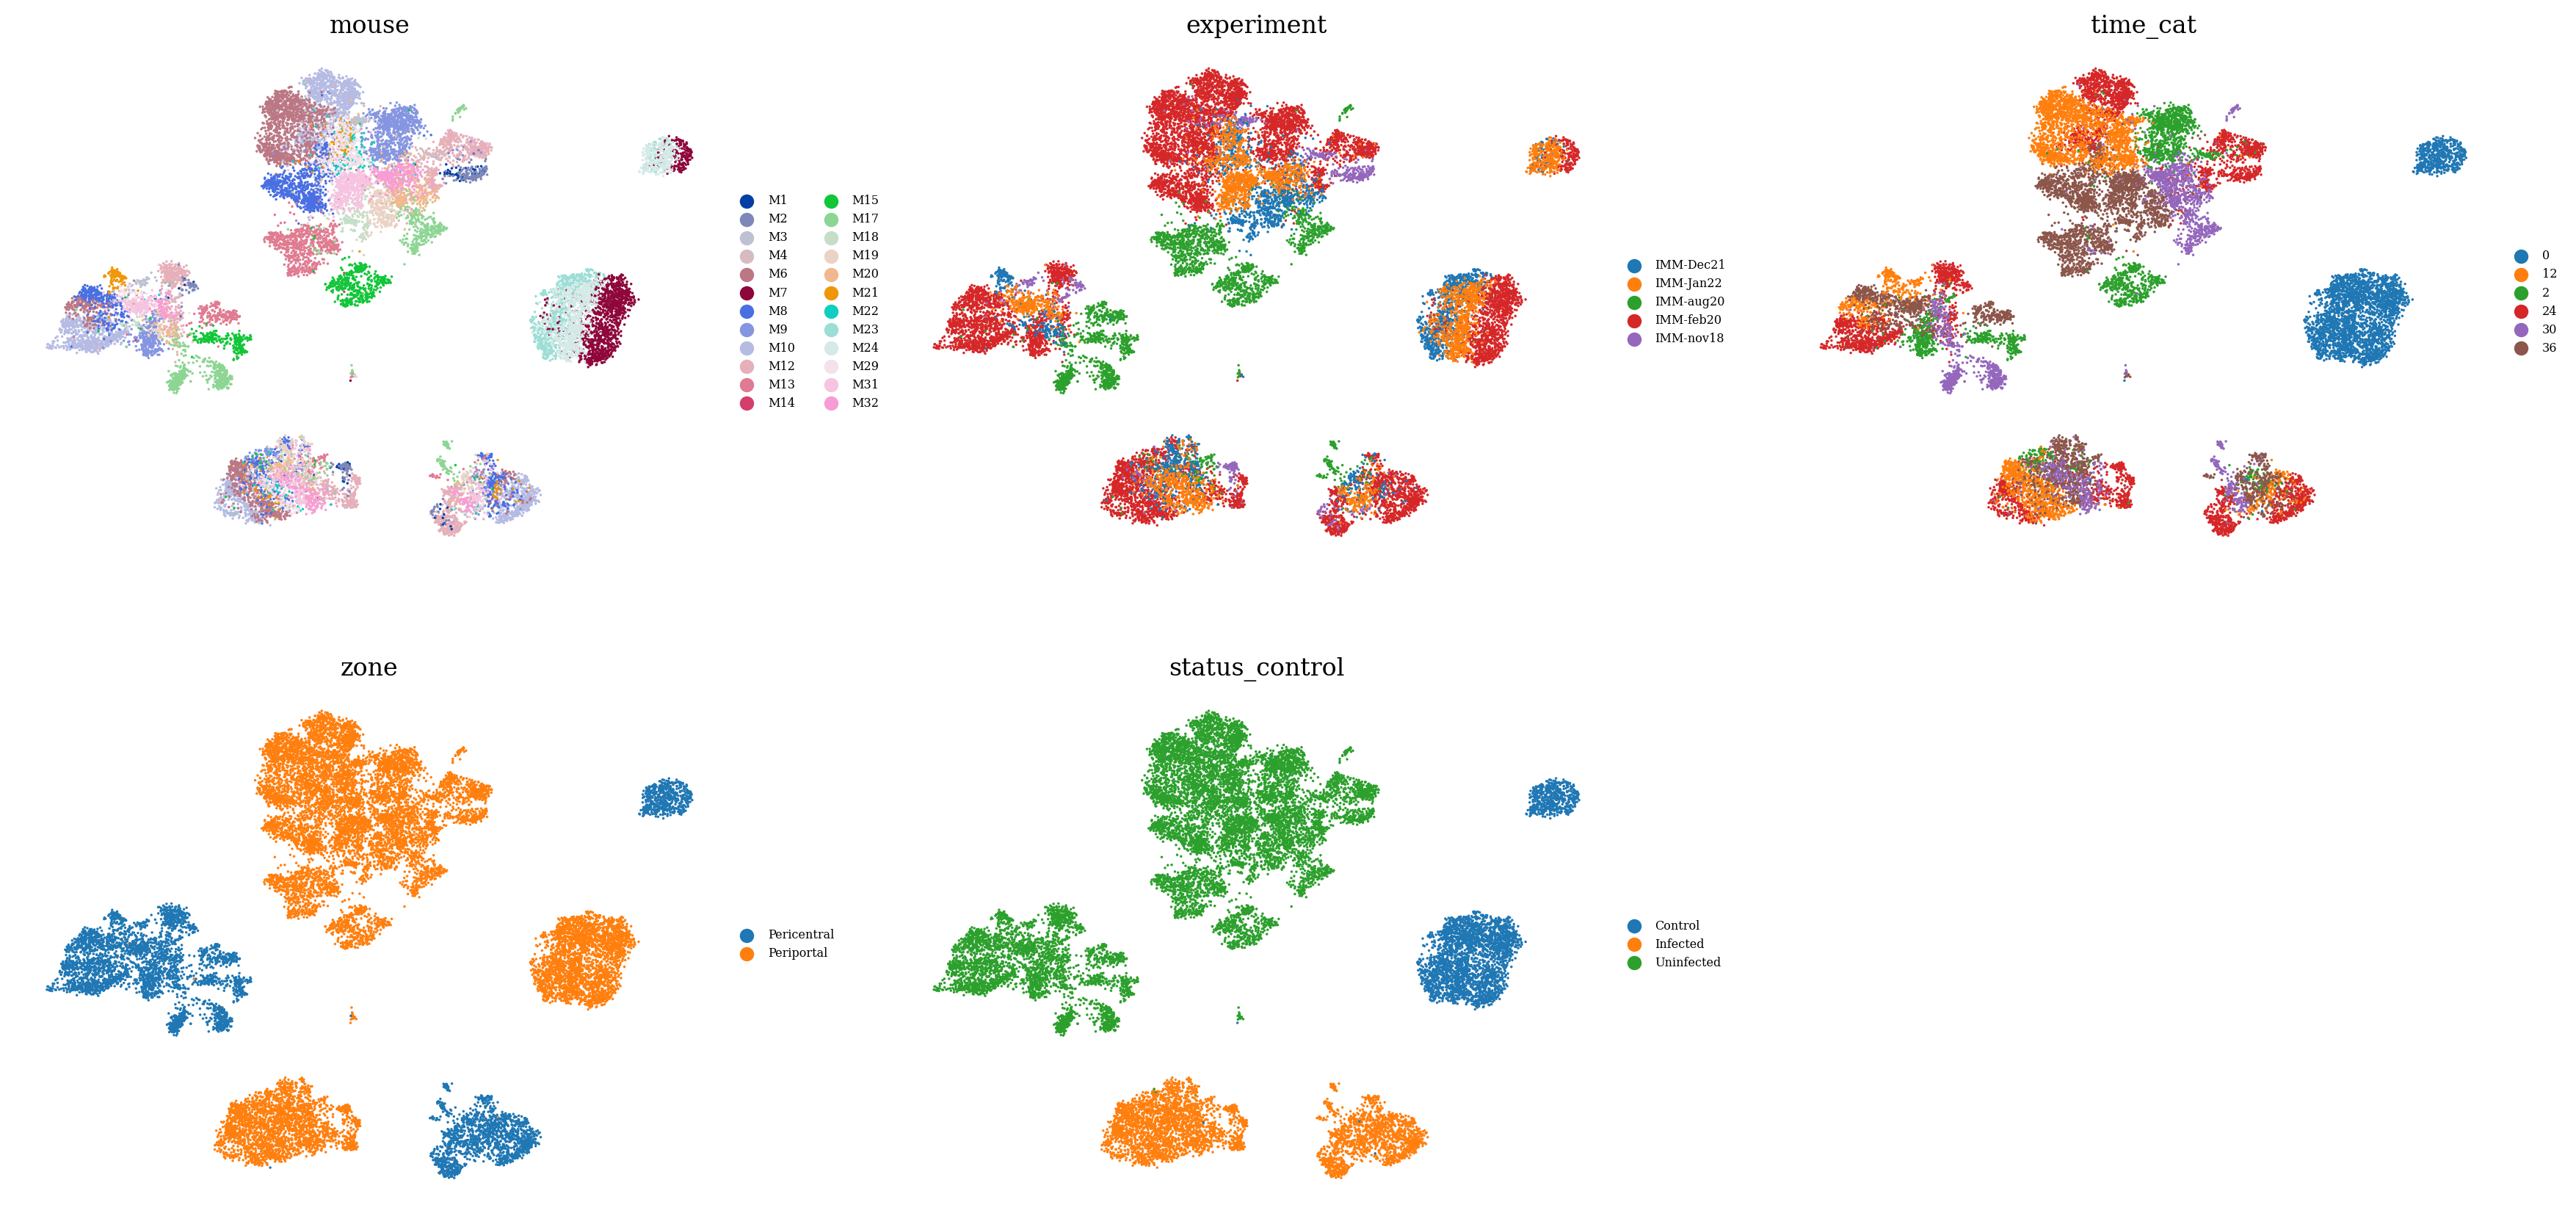

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

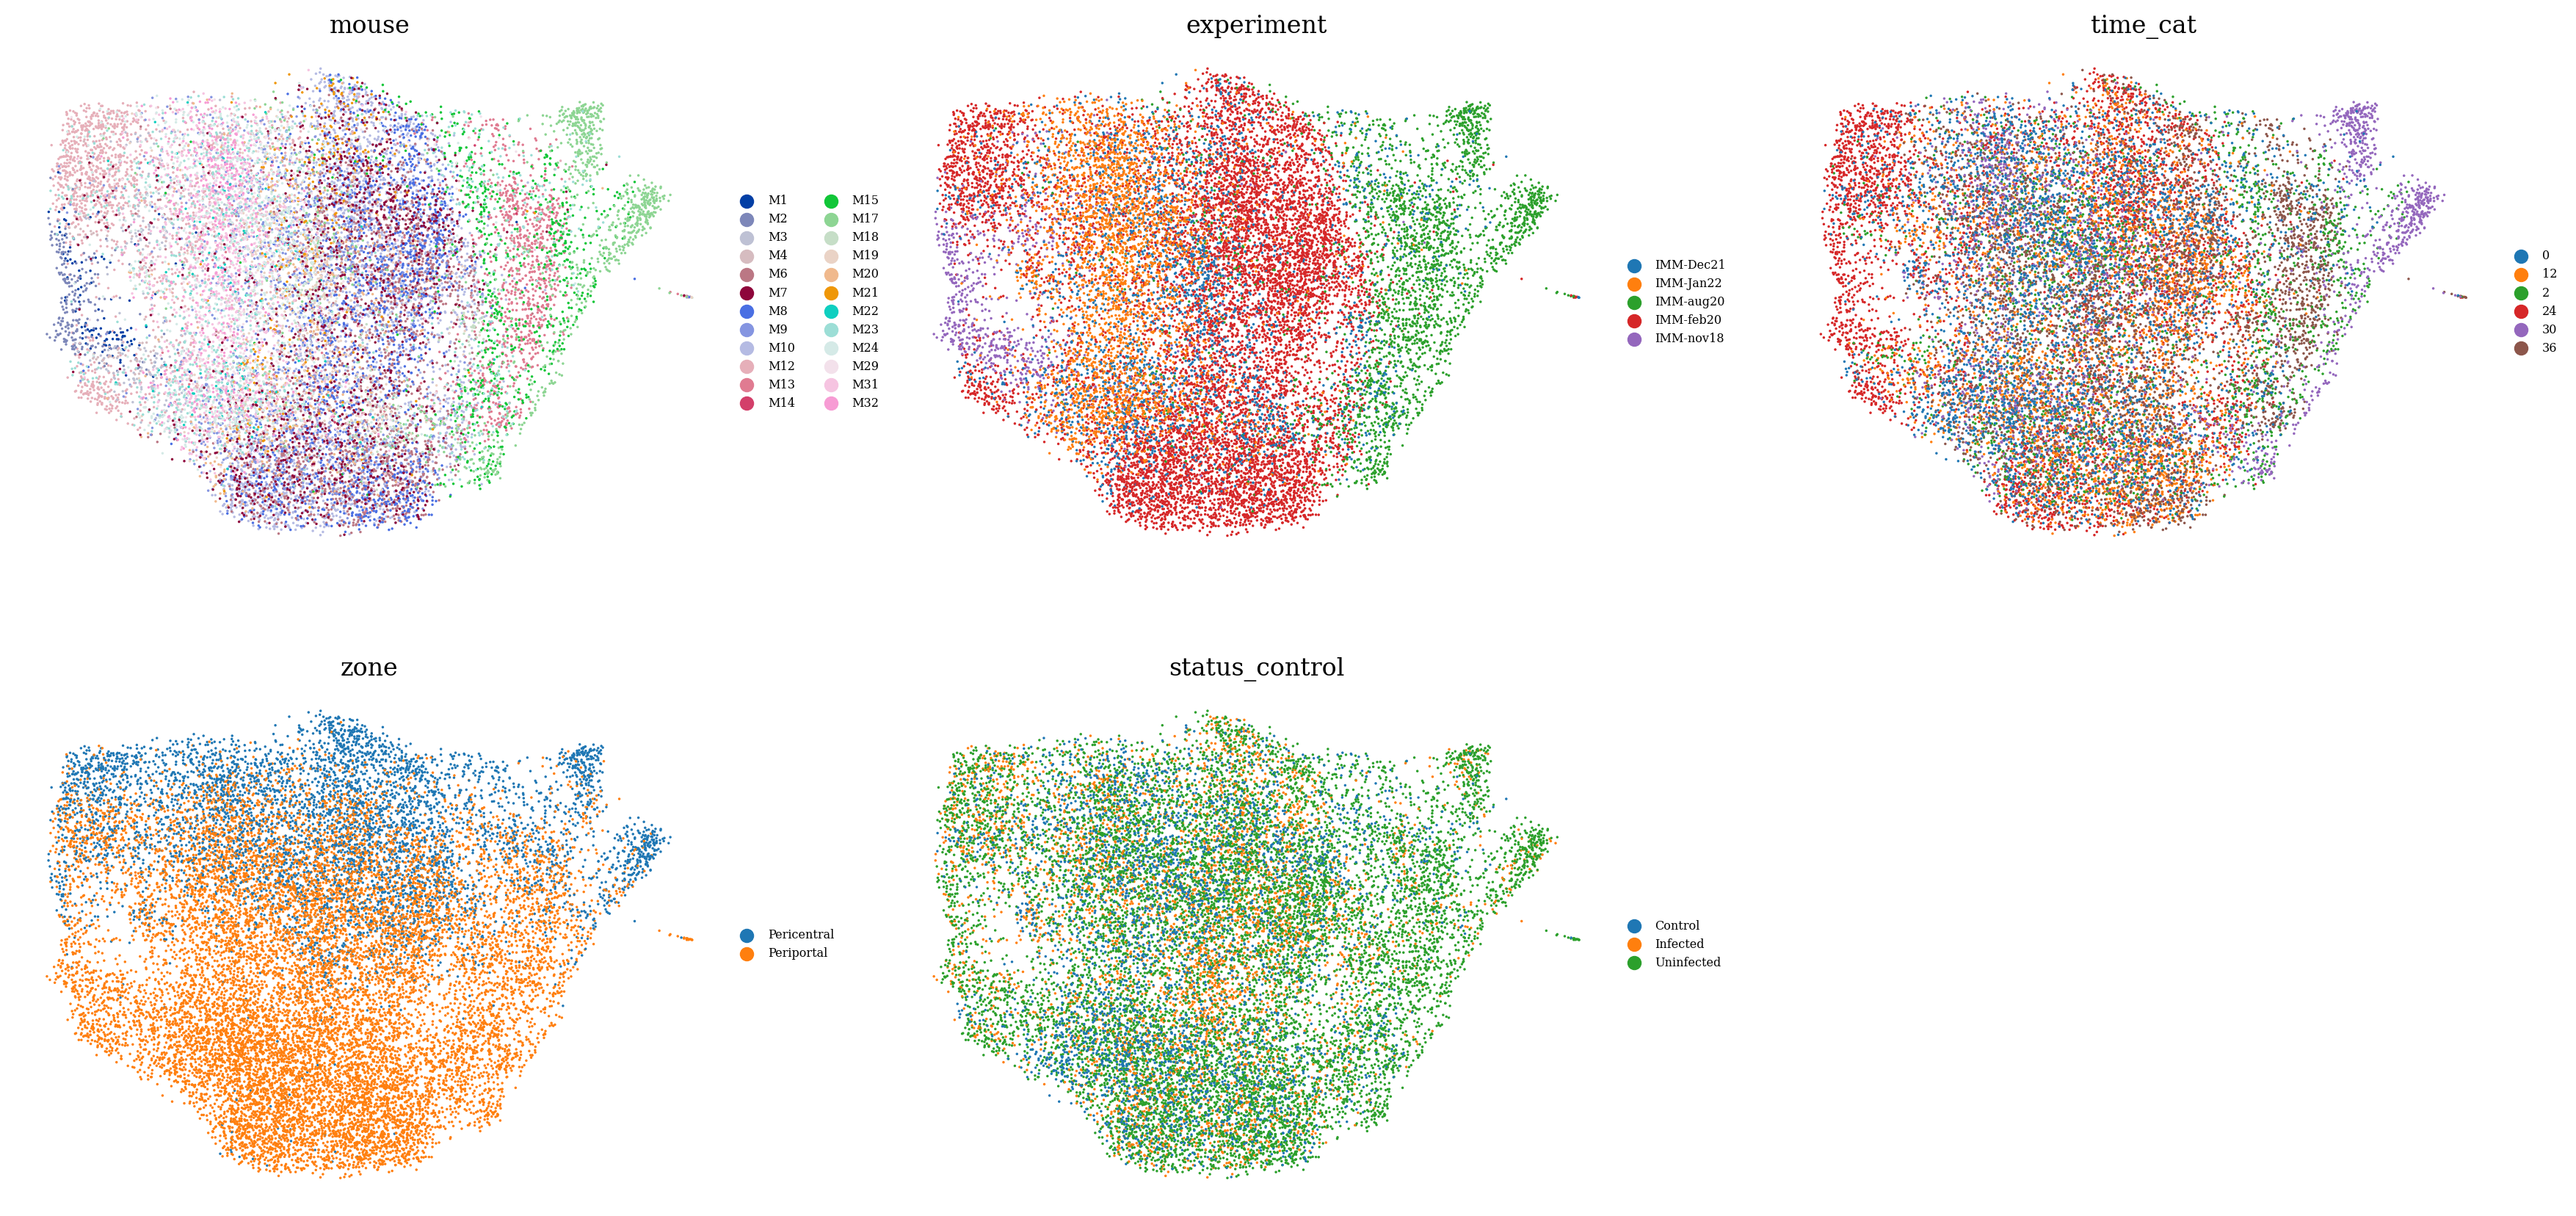

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  1%|          | 7/596 [00:00<00:08, 69.42it/s]

  5%|▌         | 32/596 [00:00<00:03, 171.65it/s]

 10%|▉         | 57/596 [00:00<00:02, 206.26it/s]

 14%|█▍        | 82/596 [00:00<00:02, 222.93it/s]

 18%|█▊        | 107/596 [00:00<00:02, 232.17it/s]

 22%|██▏       | 132/596 [00:00<00:01, 235.70it/s]

 26%|██▋       | 157/596 [00:00<00:01, 237.47it/s]

 30%|███       | 181/596 [00:00<00:01, 238.24it/s]

 35%|███▍      | 206/596 [00:00<00:01, 239.69it/s]

 39%|███▉      | 231/596 [00:01<00:01, 240.03it/s]

 43%|████▎     | 256/596 [00:01<00:01, 240.52it/s]

 47%|████▋     | 281/596 [00:01<00:01, 241.35it/s]

 51%|█████▏    | 306/596 [00:01<00:01, 241.65it/s]

 56%|█████▌    | 331/596 [00:01<00:01, 241.92it/s]

 60%|█████▉    | 356/596 [00:01<00:00, 241.61it/s]

 64%|██████▍   | 381/596 [00:01<00:00, 241.84it/s]

 68%|██████▊   | 406/596 [00:01<00:00, 241.82it/s]

 72%|███████▏  | 431/596 [00:01<00:00, 241.67it/s]

 77%|███████▋  | 456/596 [00:01<00:00, 241.81it/s]

 81%|████████  | 481/596 [00:02<00:00, 241.81it/s]

 85%|████████▍ | 506/596 [00:02<00:00, 239.78it/s]

 89%|████████▉ | 530/596 [00:02<00:00, 239.48it/s]

 93%|█████████▎| 555/596 [00:02<00:00, 240.82it/s]

 97%|█████████▋| 580/596 [00:02<00:00, 241.55it/s]

100%|██████████| 596/596 [00:02<00:00, 235.30it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

In [23]:
np.mean(r2s)

0.9651542833378799

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)